In [11]:
from scripts.get_data import get_processed_data
from scripts.models import VotingClassifier
from timeit import default_timer as timer
import numpy as np
import matplotlib.pyplot as plt
from seaborn import regplot

In [2]:
data, labels = get_processed_data(
    corr_thresh=0.9,
    minmax_scale=True,
    var_thresh=0.01
)

In [3]:
data_arr, labels_arr = np.array(data), np.array(labels)

## Voting ensemble

In [8]:
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_absolute_error as mae, median_absolute_error as med, r2_score as r2
from sklearn.feature_selection import SelectKBest, f_regression
from warnings import catch_warnings, simplefilter
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

splitter = LeaveOneOut()
true_labels = []
pred_labels = []
base_estimator = SVC(kernel='linear')
train_time, eval_time = 0.0, 0.0

with catch_warnings():
    simplefilter('ignore')
    for fold, (train_ind, val_ind) in enumerate(splitter.split(data_arr)):
        model = VotingClassifier(20, base_estimator)
        X_train = data_arr[train_ind]
        X_val = data_arr[val_ind]
        Y_train = labels_arr[train_ind]
        Y_val = labels_arr[val_ind]
        feat_sel = SelectKBest(score_func=f_regression, k=1000)
        X_train_sel = feat_sel.fit_transform(X_train, Y_train)
        X_val_sel = feat_sel.transform(X_val)

        start_time = timer()
        model.fit(X_train_sel, Y_train)
        train_time += timer() - start_time

        start_time = timer()
        pred = model.predict(X_val_sel).reshape(-1,)
        eval_time += timer() - start_time

        true_labels.append(Y_val[0])
        pred_labels.append(pred[0])

        print(f'[Fold {fold+1}/{splitter.get_n_splits(data_arr)}] ==> True label: {true_labels[-1]}, Prediction: {pred_labels[-1]}')

print(f'Average train time: {(train_time / splitter.get_n_splits(data_arr)):.6f}, Average eval time: {(eval_time / splitter.get_n_splits(data_arr)):.6f}')

[Fold 1/133] ==> True label: 19, Prediction: 21
[Fold 2/133] ==> True label: 19, Prediction: 29
[Fold 3/133] ==> True label: 19, Prediction: 19
[Fold 4/133] ==> True label: 19, Prediction: 19
[Fold 5/133] ==> True label: 20, Prediction: 19
[Fold 6/133] ==> True label: 20, Prediction: 66
[Fold 7/133] ==> True label: 31, Prediction: 17
[Fold 8/133] ==> True label: 31, Prediction: 29
[Fold 9/133] ==> True label: 32, Prediction: 26
[Fold 10/133] ==> True label: 32, Prediction: 32
[Fold 11/133] ==> True label: 33, Prediction: 12
[Fold 12/133] ==> True label: 33, Prediction: 52
[Fold 13/133] ==> True label: 37, Prediction: 23
[Fold 14/133] ==> True label: 37, Prediction: 39
[Fold 15/133] ==> True label: 37, Prediction: 70
[Fold 16/133] ==> True label: 39, Prediction: 20
[Fold 17/133] ==> True label: 51, Prediction: 61
[Fold 18/133] ==> True label: 52, Prediction: 31
[Fold 19/133] ==> True label: 55, Prediction: 32
[Fold 20/133] ==> True label: 57, Prediction: 43
[Fold 21/133] ==> True label:

In [10]:
mae_val = mae(true_labels, pred_labels)
med_val = med(true_labels, pred_labels)
r2_val = r2(true_labels, pred_labels)
print(f'MAE = {mae_val:.4f}, MED = {med_val:.4f}, R2 = {r2_val:.4f}')

MAE = 9.7669, MED = 4.0000, R2 = 0.6975


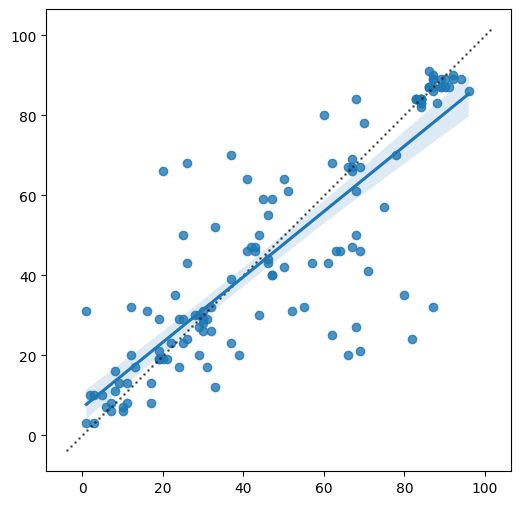

In [18]:
plt.figure(figsize=(6, 6))
regplot(x=true_labels, y=pred_labels)
xmin, xmax = plt.xlim()
plt.scatter(np.arange(xmin, xmax+1), np.arange(xmin, xmax+1), c='black', s=1, alpha=0.5)